<a href="https://colab.research.google.com/github/nikalitt1/Clementine-Agriculture/blob/main/Clementine_Ag_W_A_S_P_Setup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

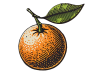

# Clementine Agriculture Tutorial: Training, deployment and setup of scripts for the W.A.S.P and other modules

Welcome!

This tutorial will include:
* Setting up Jetson Orin Nano for deploymeny in Clementine Ag products
*Scripts for product operation, training, and datacollection


First, run the following commands on the Jetson orin nano after initial boot into Jetpack 6.2 in order have all the packages run properly. These setup commands can be found in the following links as well:
* https://docs.luxonis.com/hardware/platform/deploy/to-jetson/
* https://docs.ultralytics.com/guides/nvidia-jetson/#install-ultralytics-package
* https://docs.ultralytics.com/modes/train/#apple-silicon-mps-training


# Step 1: Initial Jetson Orin Nano setup

In [ ]:
sudo apt update && sudo apt upgrade
sudo reboot now

In [ ]:
# Disable ZRAM:
sudo systemctl disable nvzramconfig
# Create 4GB swap file
sudo fallocate -l 4G /mnt/4GB.swap
sudo chmod 600 /mnt/4GB.swap
sudo mkswap /mnt/4GB.swap

In [ ]:
sudo vi /etc/fstab
# Add this line at the bottom of the file
/mnt/4GB.swap swap swap defaults 0 0
# Reboot
sudo reboot now

In [ ]:
sudo wget -qO- https://docs.luxonis.com/install_dependencies.sh | bash

This next step is to start a virtual environment on the Jetson ON, but because this computer will not be used as a general device and is only running the scripts for the W.A.S.P, its not mandatory.

In [ ]:
sudo apt install python3-venv
python3 -m venv depthai
source depthai/bin/activate

In [ ]:
#Clone github repository
git clone https://github.com/luxonis/depthai-python.git
cd depthai-python
python3 examples/install_requirements.py

In [ ]:
echo "export OPENBLAS_CORETYPE=ARMV8" >> ~/.bashrc

Once you have copy and pasted each of these commands into a freshly botted Jetson ON running Jetpack 6.2, the OAK D Lite camera should work when connected to the Jetson ON via USB port.

The next commands should also be run on the Jetson ON, they are the setup commands so that Ultralytics YOLO models can run on the Jetson ON properly.

In [ ]:
sudo apt update
sudo apt install python3-pip -y
pip install -U pip

In [ ]:
pip install ultralytics

In [ ]:
sudo reboot

In [ ]:
pip install https://github.com/ultralytics/assets/releases/download/v0.0.0/torch-2.5.0a0+872d972e41.nv24.08-cp310-cp310-linux_aarch64.whl
pip install https://github.com/ultralytics/assets/releases/download/v0.0.0/torchvision-0.20.0a0+afc54f7-cp310-cp310-linux_aarch64.whl

In [ ]:
wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/arm64/cuda-keyring_1.1-1_all.deb
sudo dpkg -i cuda-keyring_1.1-1_all.deb
sudo apt-get update
sudo apt-get -y install libcusparselt0 libcusparselt-dev

In [ ]:
pip install https://github.com/ultralytics/assets/releases/download/v0.0.0/onnxruntime_gpu-1.20.0-cp310-cp310-linux_aarch64.whl

In [ ]:
pip install numpy==1.23.5

Since numpy will be version 1.23.5 on the Jetson ON, you also need to install that version in this colab to ensure when any training scripts are run in this colab it will use the same version of numpy. If you do not do this the trained model will not work once you transfer it to the Jeton ON. Run the command below in this colab:

In [ ]:
!pip install numpy==1.23.5

#Step 2: Collecting Data for Object Detection

Connect an oak d lite camera to this computer via a usbc cable, run the below script and collect as much high uality video feed of the objecdts you want to identify, keep in mind colab does not have access to the computer hardware so the below script needs to be run on jupyter notebook instead:

In [ ]:
import cv2
import depthai as dai

# Create pipeline
pipeline = dai.Pipeline()

# Define sources and outputs
cam_rgb = pipeline.create(dai.node.ColorCamera)
xout_video = pipeline.create(dai.node.XLinkOut)

xout_video.setStreamName("video")

# Set camera properties
cam_rgb.setBoardSocket(dai.CameraBoardSocket.RGB)
cam_rgb.setResolution(dai.ColorCameraProperties.SensorResolution.THE_1080_P)
cam_rgb.setFps(30)

# Link the camera's 'preview' output to the XLinkOut node
cam_rgb.video.link(xout_video.input)

# Output file properties
output_file = "oakd_pro_out4.avi"
frame_width = 1920
frame_height = 1080
fps = 30
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_file, fourcc, fps, (frame_width, frame_height))

# Connect to the device and start the pipeline
with dai.Device(pipeline) as device:
    print("Connected to OAK-D Lite. Press 'q' to quit.")

    # Get the output queue for the video stream
    video_queue = device.getOutputQueue(name="video", maxSize=4, blocking=False)

    while True:
        # Check if a new frame is available
        in_video = video_queue.tryGet()
        if in_video:
            frame = in_video.getCvFrame()

            # Write the frame to the video file
            out.write(frame)

            # Display the frame
            cv2.imshow("OAK-D Lite Video", frame)

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

# Release resources
out.release()
cv2.destroyAllWindows()
print(f"Video saved to {output_file}")


<ipython-input-5-a5e381080b58>:14: DeprecationWarning: RGB is deprecated, use CAM_A or address camera by name instead.
  cam_rgb.setBoardSocket(dai.CameraBoardSocket.RGB)


RuntimeError: Cannot find any device with given deviceInfo

# Step 3: Training Ultralytics YOLO11n Model

The annotating and dataset preparation can be done for any model in Roboflow, make sure to export the dataset as a zip file in "YOLO V5 Pytorch format". From here on it will be assumed the dataset is already prepared and saved.

Upload the dataset zip file from roboflow in the side bar, then run the following commands to trin the yolo11n model. make sure to change the file names accordingly, and modify the data.yaml file to match the actual paths to the train, test, and validation paths.

In [ ]:
!unzip -q /content/roboflow_dataset.zip -d /content/dataset/

In [ ]:

!yolo detect train data=data.yaml model=yolo11n.yaml epochs=100 imgsz=640

once run, the model weights can be found in the following file path in the side bar: /yolov5/runs/train/exp/weights/best.pt

you can now send the model weights (best.pt) to the Jetson ON.

Now on the Jetson ON, you cannot directly run the best.pt file, you first need to convert it to a .engine file with the following command, make sure to run this command on the Jetson ON!

In [ ]:
yolo export model=yolo11n.pt format=engine # creates 'yolo11n.engine'

Great, now the object detection setup is done, now its time to train two random forest models to get the W.A.S.P arms to aim accurately at the targets identified by the YOLO11n model.

#Step 4: Training Random Forest Aiming Model

Random forests are a type of decision tree which can be thought of as a precursor to neural nets. They are better for maping pixel and depth coordinates to servo motor agles then traditional nurel nets because they are more robust when new data it has not been trainined on is presented. In the future the W.A.S.P will be training using reinforced learning methods in order to make sure it aims accurately and properly in a number of different scenarios. Unfortunately, Random forests cannot be fine tuned in real time like reinforced learning models. but for ealy models random forests are more then enough to aim accurately in most settings. The code below should be ran on the Jetson ON, it is used to collect data for the random forests model, remember to change the pin numbers for each arm:

In [ ]:
import cv2
import depthai as dai
import time
import threading
import numpy as np
import csv
from smbus2 import SMBus
import math  # For atan2

# PCA9685 Constants
PCA9685_ADDRESS = 0x40
MODE1 = 0x00
MODE2 = 0x01
LED0_ON_L = 0x06
LED0_ON_H = 0x07
LED0_OFF_L = 0x08
LED0_OFF_H = 0x09

bus = SMBus(7)

# Initialize PCA9685
def init_pca9685():
    bus.write_byte_data(PCA9685_ADDRESS, MODE1, 0x00)
    bus.write_byte_data(PCA9685_ADDRESS, MODE2, 0x04)
    time.sleep(0.1)

# Set PWM for servo motors
def set_pwm(channel, pulse_width):
    on_time = 0
    off_time = int(pulse_width)
    bus.write_byte_data(PCA9685_ADDRESS, LED0_ON_L + 4 * channel, on_time & 0xFF)
    bus.write_byte_data(PCA9685_ADDRESS, LED0_ON_H + 4 * channel, (on_time >> 8) & 0xFF)
    bus.write_byte_data(PCA9685_ADDRESS, LED0_OFF_L + 4 * channel, off_time & 0xFF)
    bus.write_byte_data(PCA9685_ADDRESS, LED0_OFF_H + 4 * channel, (off_time >> 8) & 0xFF)

def angle_to_pulse_width(angle, min_us=500, max_us=2500):
    return int((angle / 180.0) * (max_us - min_us) + min_us)

# Control the laser diode
def control_diode(on=True):
    pulse_width = int((0.3 / 100.0) * 4095)
    set_pwm(13, pulse_width if on else 0)

# Save data to CSV
def save_to_csv(angle_0, angle_1, depth, center_x, center_y, tilt_x, tilt_y):
    with open('mlp_training_data_long.csv', mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([angle_0, angle_1, depth, center_x, center_y, tilt_x, tilt_y])


import numpy as np

def generate_zigzag_path(x_range, y_range, x_step, y_step, start_corner='top-left', zigzag_axis='horizontal'):
    path = []
    x_min, x_max = x_range
    y_min, y_max = y_range

    # Generate the axis ranges using numpy to support floats
    x_forward = np.arange(x_min, x_max + x_step, x_step)
    x_backward = x_forward[::-1]
    y_forward = np.arange(y_min, y_max + y_step, y_step)
    y_backward = y_forward[::-1]

    corners = {
        'top-left':     (x_forward,  y_forward),
        'top-right':    (x_backward, y_forward),
        'bottom-left':  (x_forward,  y_backward),
        'bottom-right': (x_backward, y_backward)
    }

    if start_corner not in corners:
        raise ValueError(f"Invalid start_corner '{start_corner}'. Choose from: {list(corners.keys())}")
    if zigzag_axis not in ['horizontal', 'vertical']:
        raise ValueError("zigzag_axis must be 'horizontal' or 'vertical'")

    x_order, y_order = corners[start_corner]

    if zigzag_axis == 'horizontal':
        for i, y in enumerate(y_order):
            x_values = x_order if i % 2 == 0 else x_order[::-1]
            for x in x_values:
                path.append((round(x, 6), round(y, 6)))
    else:  # vertical
        for i, x in enumerate(x_order):
            y_values = y_order if i % 2 == 0 else y_order[::-1]
            for y in y_values:
                path.append((round(x, 6), round(y, 6)))

    return path



# Calculate tilt from accelerometer data
def calculate_tilt(accel_x, accel_y, accel_z):
    tilt_x = math.atan2(accel_x, math.sqrt(accel_y**2 + accel_z**2))  # Pitch
    tilt_y = math.atan2(accel_y, math.sqrt(accel_x**2 + accel_z**2))  # Roll
    return math.degrees(tilt_x), math.degrees(tilt_y)  # Convert radians to degrees

def move_servos(angle_list, video_queue, depth_queue, imu_queue, stop_event):
    angle_index = 0
    direction = 1  # 1 for forward, -1 for reverse

    while not stop_event.is_set():
        angle_x, angle_y = angle_list[angle_index]

        # Capture frame and depth before moving the servos
        frame_data = video_queue.get()
        frame = frame_data.getCvFrame()

        depth_data = depth_queue.get()
        depth_frame = depth_data.getFrame()

        imu_data = imu_queue.get()
        imu_packets = imu_data.packets

        tilt_x, tilt_y = 0, 0  # Default tilt values
        for imu_packet in imu_packets:
            gyro_data = imu_packet.gyroscope
            accel_data = imu_packet.acceleroMeter  # Assuming accelerometer data is available

            accel_x = accel_data.x
            accel_y = accel_data.y
            accel_z = accel_data.z

            tilt_x, tilt_y = calculate_tilt(accel_x, accel_y, accel_z)

            print(f"Tilt Data - Pitch: {tilt_x:.2f}, Roll: {tilt_y:.2f}")

        # Process frame to find brightest spot
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # Convert to grayscale and blur to reduce noise
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)

        # Apply a threshold to extract bright regions
        _, thresh = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY)

        # Find contours of bright areas
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            # Find the largest bright area (by contour area)
            largest_contour = max(contours, key=cv2.contourArea)

            # Get the bounding box and center of the largest contour
            x, y, w, h = cv2.boundingRect(largest_contour)
            center_x = x + w // 2
            center_y = y + h // 2

            # Optionally draw the bounding box and center
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 255), 2)
            cv2.circle(frame, (center_x, center_y), 3, (0, 0, 255), -1)
        else:
            center_x, center_y = -1, -1  # No bright spot found


        # Draw a bounding circle around the brightest spot
        cv2.circle(frame, (center_x, center_y), 2, (0, 255, 0), 2)

        depth_value = np.mean(depth_frame)

        # Save the data
        save_to_csv(angle_x, angle_y, round(depth_value), center_x, center_y, round(tilt_x, 2), round(tilt_y, 2))

        # Move servos
        set_pwm(15, angle_to_pulse_width(angle_x))
        set_pwm(14, angle_to_pulse_width(angle_y))

        control_diode(True)  # Turn on laser

        # Update index with direction
        angle_index += direction

        # Reverse direction at ends
        if angle_index == len(angle_list) - 1 or angle_index == 0:
            direction *= -1

        time.sleep(0.5)  # Adjust delay if needed


# Setup depthai pipeline
def setup_depthai_pipeline():
    pipeline = dai.Pipeline()

    # Color Camera
    cam_rgb = pipeline.create(dai.node.ColorCamera)
    cam_rgb.setPreviewSize(640, 360)
    cam_rgb.setBoardSocket(dai.CameraBoardSocket.CAM_A)
    cam_rgb.setResolution(dai.ColorCameraProperties.SensorResolution.THE_1080_P)
    cam_rgb.setInterleaved(False)
    cam_rgb.setColorOrder(dai.ColorCameraProperties.ColorOrder.BGR)
    cam_rgb.setFps(35)

    # Depth Camera
    mono_left = pipeline.create(dai.node.MonoCamera)
    mono_right = pipeline.create(dai.node.MonoCamera)
    stereo = pipeline.create(dai.node.StereoDepth)

    mono_left.setResolution(dai.MonoCameraProperties.SensorResolution.THE_480_P)
    mono_right.setResolution(dai.MonoCameraProperties.SensorResolution.THE_480_P)
    mono_left.setBoardSocket(dai.CameraBoardSocket.LEFT)
    mono_right.setBoardSocket(dai.CameraBoardSocket.RIGHT)

    stereo.setDefaultProfilePreset(dai.node.StereoDepth.PresetMode.HIGH_DENSITY)
    stereo.setLeftRightCheck(True)
    stereo.setDepthAlign(dai.CameraBoardSocket.CAM_A)
    stereo.setSubpixel(True)

    mono_left.out.link(stereo.left)
    mono_right.out.link(stereo.right)

    #IMU
    imu = pipeline.create(dai.node.IMU)
    imu.enableIMUSensor(dai.IMUSensor.GYROSCOPE_RAW, 100)
    imu.enableIMUSensor(dai.IMUSensor.ACCELEROMETER_RAW, 100)
    imu_queue = pipeline.create(dai.node.XLinkOut)
    imu_queue.setStreamName("imu")
    imu.out.link(imu_queue.input)

    # Output Streams
    xout_rgb = pipeline.create(dai.node.XLinkOut)
    xout_rgb.setStreamName("rgb")
    xout_depth = pipeline.create(dai.node.XLinkOut)
    xout_depth.setStreamName("depth")

    cam_rgb.preview.link(xout_rgb.input)
    stereo.depth.link(xout_depth.input)

    return pipeline

def main():
    init_pca9685()

    # Generate the angle list for flat its (25, 90) and (25, 59) for long its (20, 80) and (40, 75)
    angle_list = generate_zigzag_path((25, 80), (40, 70), 1, 1, 'top-left', 'horizontal')

    # Setup depthai pipeline
    pipeline = setup_depthai_pipeline()

    # Start depthai device
    with dai.Device(pipeline) as device:
        video_queue = device.getOutputQueue(name="rgb", maxSize=4, blocking=False)
        depth_queue = device.getOutputQueue(name="depth", maxSize=4, blocking=False)
        imu_queue = device.getOutputQueue(name="imu", maxSize=4, blocking=False)
        # Stop event to manage the thread
        stop_event = threading.Event()

        # Start the servo movement and data collection in a separate thread
        threading.Thread(target=move_servos, args=(angle_list, video_queue, depth_queue, imu_queue, stop_event), daemon=True).start()

        while True:
            try:
                frame_data = video_queue.get()
                frame = frame_data.getCvFrame()

                # Convert to grayscale and blur to reduce noise
                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                blurred = cv2.GaussianBlur(gray, (5, 5), 0)

                # Apply a threshold to extract bright regions
                _, thresh = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY)

                # Find contours of bright areas
                contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                if contours:
                    # Find the largest bright area (by contour area)
                    largest_contour = max(contours, key=cv2.contourArea)

                    # Get the bounding box and center of the largest contour
                    x, y, w, h = cv2.boundingRect(largest_contour)
                    center_x = x + w // 2
                    center_y = y + h // 2

                    # Draw the bounding box and center
                    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 255), 2)
                    cv2.circle(frame, (center_x, center_y), 3, (0, 0, 255), -1)
                else:
                    center_x, center_y = -1, -1
                    cv2.circle(frame, (center_x, center_y), 2, (0, 255, 0), 2)

                # Display the current frame with circle
                cv2.imshow("Detection", frame)

                if cv2.waitKey(1) == ord("q"):
                    stop_event.set()
                    break

            except KeyboardInterrupt:
                print("Shutting down...")
                stop_event.set()
                break

    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()

Once enough data with diverse depth values has been collected, upload the csv files to the sidebar on this notebook and run the code below to train the random forest model, remeber to change the file names and train both arms using seperate csv files. This means you need to run the following code twice for each csv file for each arm.

In [ ]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from google.colab import files

# Load CSV
csv_filename = "/content/mlp_training_data_flat_cleaned.csv"
df = pd.read_csv(csv_filename, header=None)
df.columns = ["angle_0", "angle_1", "depth", "center_x", "center_y", "tilt_x", "tilt_y"]

# Features and targets
y = df[["angle_0", "angle_1"]].values
x = df[["center_x", "center_y", "depth", "tilt_x", "tilt_y"]].values

# Train/test split
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

# ========== Decision Tree Regressor ==========
# Initialize and train decision tree
tree = DecisionTreeRegressor(max_depth=22, random_state=42)
tree.fit(X_train, y_train)

# Save the decision tree model
tree_model_path = "/content/decision_tree_flat_fine2.pkl"
with open(tree_model_path, 'wb') as f:
    pickle.dump(tree, f)

print(f"Decision tree trained and saved to {tree_model_path}")
files.download(tree_model_path)

# Predict on validation set
val_preds_tree = tree.predict(X_val)

# Compute MAE for each angle
mae_angle0_tree = mean_absolute_error(y_val[:, 0], val_preds_tree[:, 0])
mae_angle1_tree = mean_absolute_error(y_val[:, 1], val_preds_tree[:, 1])
avg_mae_tree = (mae_angle0_tree + mae_angle1_tree) / 2

print(f"\nDecision Tree Validation MAE:")
print(f"  angle_0: {mae_angle0_tree:.2f} degrees")
print(f"  angle_1: {mae_angle1_tree:.2f} degrees")
print(f"  Average MAE: {avg_mae_tree:.2f} degrees")

# ====== Compare Predictions to Actuals ======
print("\nSample Predictions vs Actual Values for Decision Tree:")
for i in range(10):
    predicted = val_preds_tree[i]
    actual = y_val[i]
    print(f"[{i}] Predicted: angle_0 = {predicted[0]:.2f}, angle_1 = {predicted[1]:.2f}  |  Actual: angle_0 = {actual[0]:.2f}, angle_1 = {actual[1]:.2f}")


# ========== Random Forest Regressor ==========
# Initialize and train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Save the Random Forest model
rf_model_path = "/content/random_forest_flat_fine2.pkl"
with open(rf_model_path, 'wb') as f:
    pickle.dump(rf, f)

print(f"Random Forest trained and saved to {rf_model_path}")
files.download(rf_model_path)

# Predict on validation set for Random Forest
val_preds_rf = rf.predict(X_val)

# Compute MAE for Random Forest
mae_angle0_rf = mean_absolute_error(y_val[:, 0], val_preds_rf[:, 0])
mae_angle1_rf = mean_absolute_error(y_val[:, 1], val_preds_rf[:, 1])
avg_mae_rf = (mae_angle0_rf + mae_angle1_rf) / 2

print(f"\nRandom Forest Validation MAE:")
print(f"  angle_0: {mae_angle0_rf:.2f} degrees")
print(f"  angle_1: {mae_angle1_rf:.2f} degrees")
print(f"  Average MAE: {avg_mae_rf:.2f} degrees")

# ====== Compare Predictions to Actuals ======
print("\nSample Predictions vs Actual Values for Random Forest:")
for i in range(10):
    predicted = val_preds_rf[i]
    actual = y_val[i]
    print(f"[{i}] Predicted: angle_0 = {predicted[0]:.2f}, angle_1 = {predicted[1]:.2f}  |  Actual: angle_0 = {actual[0]:.2f}, angle_1 = {actual[1]:.2f}")



Decision tree trained and saved to /content/decision_tree_flat_fine2.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Decision Tree Validation MAE:
  angle_0: 1.03 degrees
  angle_1: 0.17 degrees
  Average MAE: 0.60 degrees

Sample Predictions vs Actual Values for Decision Tree:
[0] Predicted: angle_0 = 59.00, angle_1 = 28.60  |  Actual: angle_0 = 59.20, angle_1 = 28.60
[1] Predicted: angle_0 = 28.60, angle_1 = 41.60  |  Actual: angle_0 = 28.60, angle_1 = 41.20
[2] Predicted: angle_0 = 48.80, angle_1 = 25.80  |  Actual: angle_0 = 46.80, angle_1 = 26.40
[3] Predicted: angle_0 = 51.40, angle_1 = 27.20  |  Actual: angle_0 = 52.00, angle_1 = 26.80
[4] Predicted: angle_0 = 59.60, angle_1 = 31.40  |  Actual: angle_0 = 59.80, angle_1 = 31.40
[5] Predicted: angle_0 = 49.60, angle_1 = 51.00  |  Actual: angle_0 = 49.40, angle_1 = 51.00
[6] Predicted: angle_0 = 74.20, angle_1 = 35.40  |  Actual: angle_0 = 74.00, angle_1 = 35.40
[7] Predicted: angle_0 = 28.40, angle_1 = 50.00  |  Actual: angle_0 = 28.20, angle_1 = 50.00
[8] Predicted: angle_0 = 51.80, angle_1 = 29.00  |  Actual: angle_0 = 51.80, angle_1 = 28.20


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Random Forest Validation MAE:
  angle_0: 0.92 degrees
  angle_1: 0.13 degrees
  Average MAE: 0.52 degrees

Sample Predictions vs Actual Values for Random Forest:
[0] Predicted: angle_0 = 57.99, angle_1 = 28.70  |  Actual: angle_0 = 59.20, angle_1 = 28.60
[1] Predicted: angle_0 = 28.70, angle_1 = 41.39  |  Actual: angle_0 = 28.60, angle_1 = 41.20
[2] Predicted: angle_0 = 48.98, angle_1 = 26.24  |  Actual: angle_0 = 46.80, angle_1 = 26.40
[3] Predicted: angle_0 = 52.68, angle_1 = 26.78  |  Actual: angle_0 = 52.00, angle_1 = 26.80
[4] Predicted: angle_0 = 59.51, angle_1 = 31.31  |  Actual: angle_0 = 59.80, angle_1 = 31.40
[5] Predicted: angle_0 = 48.73, angle_1 = 51.05  |  Actual: angle_0 = 49.40, angle_1 = 51.00
[6] Predicted: angle_0 = 73.95, angle_1 = 35.54  |  Actual: angle_0 = 74.00, angle_1 = 35.40
[7] Predicted: angle_0 = 28.52, angle_1 = 50.05  |  Actual: angle_0 = 28.20, angle_1 = 50.00
[8] Predicted: angle_0 = 51.42, angle_1 = 28.23  |  Actual: angle_0 = 51.80, angle_1 = 28.20


Once the .pkl random forest files have been trained, upload them to the Jetson ON.

If there are NaN values in the csv files you can run the following code to clean it up:

In [ ]:
import pandas as pd

# Path to your original CSV file
input_csv = "/content/mlp_training_data_fine_flat.csv"

# Output path for cleaned CSV
output_csv = "/content/mlp_training_data_flat_cleaned.csv"

# Load the CSV file (no header)
df = pd.read_csv(input_csv, header=None)

# Set column names
df.columns = ["angle_0", "angle_1", "depth", "center_x", "center_y", "tiltx", "tilty"]

# Drop rows with NaNs in input or target columns
df_cleaned = df.dropna(subset=["angle_0", "angle_1", "center_x", "center_y", "depth"])

# Save the cleaned DataFrame to a new CSV
df_cleaned.to_csv(output_csv, index=False, header=False)

print(f"Cleaned dataset saved to: {output_csv}")
print(f"Original rows: {len(df)}, Cleaned rows: {len(df_cleaned)}")

Cleaned dataset saved to: /content/mlp_training_data_flat_cleaned.csv
Original rows: 46129, Cleaned rows: 46078


#Step 5: Aiming While in Motion

Aiming while in motion can be difficult but can be done by predicting the target objects position based on the velocity fo the camera. the velocity of the camera can be derived based on GPS information but for the toolbar model this would require extra hardware. Thats why I decided to calcualte velocity based on the depth-optical flow in frame.

This consists of looking at how the depth pixels in frame change overtime, for example if there was some peak in frame the camaera would be able to compare how far it moved in the frame by tracking it. Traditionally optical flow is used on RGB data but because there is a blue laser targeting objects in frame it can make RGB based optical flow very inaccurate.

There is no training that needs to be done in this section, it will just be added in the main code.

#Step 6: Main code

Below is the main code, it loads the YOLO11n model and both random forest models to aim at targets specified in the code. Copy and paste the following file onto the Jetson ON as well as intall any necesary packages:

In [ ]:
import cv2
import depthai as dai
import torch
from collections import defaultdict, deque
import numpy as np
from ultralytics import YOLO
import joblib
from smbus2 import SMBus
import time
import logging
import threading
import queue
import math

# Load the YOLO model
model = YOLO("toolbar_test3.engine")

# Load Random Forest models
rf_model_long = joblib.load("random_forest_long_fine2.pkl")
rf_model_flat = joblib.load("random_forest_flat_fine2.pkl")

class KalmanFilter:
    def __init__(self):
        # Define the Kalman filter
        self.dt = 1.0

        self.A = np.array([[1, 0, self.dt, 0],
                           [0, 1, 0, self.dt],
                           [0, 0, 1, 0],
                           [0, 0, 0, 1]])

        self.B = np.array([[0],
                           [0],
                           [0],
                           [0]])

        self.H = np.array([[1, 0, 0, 0],
                           [0, 1, 0, 0]])

        self.Q = np.eye(4) * 0.1
        self.R = np.eye(2) * 10
        self.P = np.eye(4)
        self.x = np.zeros((4, 1))
        self.u = 0

    def predict(self, coordX, coordY):
        measured = np.array([[np.float32(coordX)], [np.float32(coordY)]])
        self.x = self.A @ self.x + self.B * self.u
        self.P = self.A @ self.P @ self.A.T + self.Q

        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        y = measured - self.H @ self.x
        self.x += K @ y
        self.P = (np.eye(4) - K @ self.H) @ self.P
        return int(self.x[0][0]), int(self.x[1][0])

    def predict_future(self, steps=5):
        future_x = self.x.copy()
        for _ in range(steps):
            future_x = self.A @ future_x + self.B * self.u
        return int(future_x[0][0]), int(future_x[1][0])


# Constants for PCA9685
PCA9685_ADDRESS = 0x40
MODE1, MODE2 = 0x00, 0x01
LED0_ON_L, LED0_OFF_L = 0x06, 0x08
LED0_ON_H, LED0_OFF_H = 0x07, 0x09

# I2C initialization
bus = SMBus(7)

def init_pca9685():
    bus.write_byte_data(PCA9685_ADDRESS, MODE1, 0x00)
    bus.write_byte_data(PCA9685_ADDRESS, MODE2, 0x04)
    time.sleep(0.1)

def set_pwm(channel, pulse_width):
    on_time = 0
    off_time = int(pulse_width)
    base = LED0_ON_L + 4 * channel
    bus.write_byte_data(PCA9685_ADDRESS, base, on_time & 0xFF)
    bus.write_byte_data(PCA9685_ADDRESS, base + 1, (on_time >> 8) & 0xFF)
    bus.write_byte_data(PCA9685_ADDRESS, base + 2, off_time & 0xFF)
    bus.write_byte_data(PCA9685_ADDRESS, base + 3, (off_time >> 8) & 0xFF)

def angle_to_pulse_width(angle, min_us=500, max_us=2500):
    return int((angle / 180.0) * (max_us - min_us) + min_us)

# Calculate tilt from accelerometer data
def calculate_tilt(accel_x, accel_y, accel_z):
    tilt_x = math.atan2(accel_x, math.sqrt(accel_y**2 + accel_z**2))  # Pitch
    tilt_y = math.atan2(accel_y, math.sqrt(accel_x**2 + accel_z**2))  # Roll
    return math.degrees(tilt_x), math.degrees(tilt_y)  # Convert radians to degrees

def control_diode(on=True):
    pulse_width = int((0.1 / 100.0) * 4095)
    set_pwm(13, pulse_width if on else 0)
    set_pwm(9, pulse_width if on else 0)

init_pca9685()

# OAK-D Lite pipeline setup
pipeline = dai.Pipeline()
cam_rgb = pipeline.create(dai.node.ColorCamera)
cam_rgb.setPreviewSize(640, 360)
cam_rgb.setBoardSocket(dai.CameraBoardSocket.CAM_A)
cam_rgb.setResolution(dai.ColorCameraProperties.SensorResolution.THE_1080_P)
cam_rgb.setInterleaved(False)
cam_rgb.setColorOrder(dai.ColorCameraProperties.ColorOrder.BGR)
cam_rgb.setFps(30)

mono_left = pipeline.create(dai.node.MonoCamera)
mono_right = pipeline.create(dai.node.MonoCamera)
mono_left.setBoardSocket(dai.CameraBoardSocket.CAM_B)
mono_right.setBoardSocket(dai.CameraBoardSocket.CAM_C)
mono_left.setResolution(dai.MonoCameraProperties.SensorResolution.THE_480_P)
mono_right.setResolution(dai.MonoCameraProperties.SensorResolution.THE_480_P)

stereo = pipeline.create(dai.node.StereoDepth)
stereo.setDefaultProfilePreset(dai.node.StereoDepth.PresetMode.DEFAULT)
mono_left.out.link(stereo.left)
mono_right.out.link(stereo.right)

#IMU
imu = pipeline.create(dai.node.IMU)
imu.enableIMUSensor(dai.IMUSensor.GYROSCOPE_RAW, 100)
imu.enableIMUSensor(dai.IMUSensor.ACCELEROMETER_RAW, 100)
imu_queue = pipeline.create(dai.node.XLinkOut)
imu_queue.setStreamName("imu")
imu.out.link(imu_queue.input)

xout_rgb = pipeline.create(dai.node.XLinkOut)
xout_rgb.setStreamName("rgb")
cam_rgb.preview.link(xout_rgb.input)

xout_depth = pipeline.create(dai.node.XLinkOut)
xout_depth.setStreamName("depth")
stereo.depth.link(xout_depth.input)

frame_queue = queue.Queue(maxsize=1)

trackers = {}


def frame_capture_thread():
    with dai.Device(pipeline) as device:
        video_queue = device.getOutputQueue(name="rgb", maxSize=1, blocking=False)
        depth_queue = device.getOutputQueue(name="depth", maxSize=1, blocking=False)
        imu_queue = device.getOutputQueue(name="imu", maxSize=1, blocking=False)
        while True:
            try:
                frame = video_queue.get().getCvFrame()
                depth = depth_queue.get().getCvFrame()
                imu = imu_queue.get()
                frame_queue.put((frame, depth, imu))
            except KeyboardInterrupt:
                break

kf = KalmanFilter()
# Global video writer
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video_writer = cv2.VideoWriter('output.avi', fourcc, 30.0, (640, 360))


def detection_and_control_thread():
    alpha = 0.4  # Unused here but keep if you apply smoothing later

    while True:
        try:
            if not frame_queue.empty():
                frame, depth, imu = frame_queue.get()
                results = model.track(frame, persist=True)
                current_time = time.time()
                found_mock_weed = False

                imu_packets = imu.packets
                tilt_x, tilt_y = 0, 0

                for imu_packet in imu_packets:
                    accel_data = imu_packet.acceleroMeter
                    accel_x = accel_data.x
                    accel_y = accel_data.y
                    accel_z = accel_data.z
                    tilt_x, tilt_y = calculate_tilt(accel_x, accel_y, accel_z)

                for result in results:
                    if result.boxes is not None and len(result.boxes) > 0:
                        boxes = result.boxes.xyxy.cpu().numpy()
                        track_ids = result.boxes.id.int().cpu().tolist() if result.boxes.id is not None else []
                        labels = result.boxes.cls.cpu().numpy()

                        for i, box in enumerate(boxes):
                            label = labels[i]
                            label_name = result.names[int(label)]
                            track_id = track_ids[i] if i < len(track_ids) else None
                            if track_id is None:
                                continue

                            x1, y1, x2, y2 = box
                            center_x = (x1 + x2) / 2
                            center_y = (y1 + y2) / 2


                            if label_name == "crop":
                                cv2.circle(frame, (int(center_x), int(center_y)), 40, (0, 255, 0), 2)

                            elif label_name == "mock_weed":
                                found_mock_weed = True

                                # Kalman filter prediction and correction
                                kf.predict(center_x, center_y)
                                predicted_X, predicted_y = kf.predict_future(steps=5)


                                depth_at_center = np.mean(depth)

                                cv2.circle(frame, (int(center_x), int(center_y)), 20, (0, 0, 255), 2)
                                cv2.circle(frame, (int(center_x), int(predicted_y)), 10, (0, 0, 255), 2)

                                if predicted_y > frame.shape[0] // 2:
                                    input_data = np.array([[center_x, predicted_y, depth_at_center, tilt_x, tilt_y]])
                                    angle_x_long, angle_y_long = rf_model_long.predict(input_data).flatten()
                                    angle_x_flat, angle_y_flat = rf_model_flat.predict(input_data).flatten()

                                    set_pwm(15, angle_to_pulse_width(round(angle_x_long)))
                                    set_pwm(14, angle_to_pulse_width(round(angle_y_long)))
                                    set_pwm(11, angle_to_pulse_width(round(angle_x_flat)))
                                    set_pwm(10, angle_to_pulse_width(round(angle_y_flat)))
                                    control_diode(True)
                                else:
                                    control_diode(False)

                if not found_mock_weed:
                    control_diode(False)

                cv2.imshow("Detection Output", frame)
                video_writer.write(frame)
                if cv2.waitKey(1) == ord("q"):
                    break
        except KeyboardInterrupt:
            break


# Start threads
threading.Thread(target=frame_capture_thread, daemon=True).start()
threading.Thread(target=detection_and_control_thread, daemon=True).start()

# Keep main thread alive
try:
    while True:
        time.sleep(1)
except KeyboardInterrupt:
    video_writer.release()
    cv2.destroyAllWindows()